# PPM reconstruction

In [1]:
import numpy as np
import matplotlib.pyplot as plt

A simple 1D finite-volume grid class.  This includes some methods that allow us to plot the grid.

In [253]:
class FVGrid:
    """The main finite-volume grid class for holding our fluid state."""
    
    def __init__(self, nx, ng, xmin=0.0, xmax=1.0, vars=None):

        self.xmin = xmin
        self.xmax = xmax
        self.ng = ng
        self.nx = nx

        self.lo = ng
        self.hi = ng+nx-1

        # physical coords -- cell-centered
        self.dx = (xmax - xmin)/(nx)
        self.xl = xmin + (np.arange(nx+2*ng)-ng)*self.dx
        self.xr = xmin + (np.arange(nx+2*ng)-ng+1.0)*self.dx
        self.x = xmin + (np.arange(nx+2*ng)-ng+0.5)*self.dx

    def scratch_array(self, nc=1):
        """ return a scratch array dimensioned for our grid """
        return np.squeeze(np.zeros((self.nx+2*self.ng, nc), dtype=np.float64))

    def fill_BCs(self, atmp):
        """ fill all ghost cells with zero-gradient boundary conditions """
        if atmp.ndim == 2:
            for n in range(atmp.shape[-1]):
                atmp[0:self.lo, n] = atmp[self.lo, n]
                atmp[self.hi+1:, n] = atmp[self.hi, n]            
        else:
            atmp[0:self.lo] = atmp[self.lo]
            atmp[self.hi+1:] = atmp[self.hi]

    def draw(self):
        fig, ax = plt.subplots()
        
        nstart = self.lo - self.ng
        nstop = self.hi + self.ng

        ax.plot([self.xl[nstart], self.xr[nstop]], [0, 0], color="0.25", lw=2)

        # draw edges

        for n in range(nstart, nstop+1):
            if n == self.lo:
                ax.plot([self.xl[n], self.xl[n]], [0, 1.0], color="0.25", lw=4)
            else:
                ax.plot([self.xl[n], self.xl[n]], [0, 1.0], color="0.25", lw=2)

            if n == self.hi:
                ax.plot([self.xr[n], self.xr[n]], [0, 1.0], color="0.25", lw=4)

        ax.plot([self.xr[nstop], self.xr[nstop]], [0, 1.0], color="0.25", lw=2)
        
        fig.set_size_inches((self.nx + 2 * self.ng), 1)
        ax.axis("off")
        return fig, ax

A class to manage PPM reconstruction.  This will also allow us to visualize the parabola
on the plot created by the FVGrid class.

In [254]:
class PPMInterpolant:
    """Given a fluid variable a defined on the FVGrid grid, perform
    the PPM reconstruction"""
    def __init__(self, grid, a, *, limit=True):
        self.grid = grid
        assert(grid.ng >= 3)
        
        self.a = a
        self.limit = limit

        self.aint = grid.scratch_array()
        
        self.ap = grid.scratch_array()
        self.am = grid.scratch_array()
        self.a6 = grid.scratch_array()

    def construct_parabola(self):
        # first do the cubic interpolation in zones in all but the last ghost cell
        # we will be getting a_{i+1/2}

        # the state will initially be defined on ib:ie+1
        ib = self.grid.lo-2
        ie = self.grid.hi+1
        
        da0 = self.grid.scratch_array()
        dap = self.grid.scratch_array()

        # 1/2 (a_{i+1} - a_{i-1})
        da0[ib:ie+1] = 0.5 * (self.a[ib+1:ie+2] - self.a[ib-1:ie])

        # 1/2 (a_{i+2} - a_{i})
        dap[ib:ie+1] = 0.5 * (self.a[ib+2:ie+3] - self.a[ib:ie+1])

        if self.limit:
            # van-Leer slopes
            dl = self.grid.scratch_array()
            dr = self.grid.scratch_array()
            dr[ib:ie+1] = self.a[ib+1:ie+2] - self.a[ib:ie+1]
            dl[ib:ie+1] = self.a[ib:ie+1] - self.a[ib-1:ie]

            da0 = np.where(dl * dr > 0,
                           np.sign(da0) * np.minimum(np.abs(da0),
                                                     2.0 * np.minimum(np.abs(dl),
                                                                      np.abs(dr))),
                           0.0)

            dl[:] = dr[:]
            dr[ib:ie+1] = self.a[ib+2:ie+3] - self.a[ib+1:ie+2]

            dap = np.where(dl * dr > 0,
                           np.sign(dap) * np.minimum(np.abs(dap),
                                                     2.0 * np.minimum(np.abs(dl),
                                                                      np.abs(dr))),
                           0.0)

        # cubic
        self.aint[ib:ie+1] = 0.5 * (self.a[ib:ie+1] + self.a[ib+1:ie+2]) - \
                             (1.0 / 6.0) * (dap[ib:ie+1] - da0[ib:ie+1])

        # now the parabola coefficients
        self.ap[:] = self.aint[:]
        self.am[1:] = self.ap[:-1]

        if self.limit:
            
            # now we work on each zone + 1 ghost cell and limit the parabola
            # coefficients as needed.  At the end, this will be valid on
            # lo-1:hi+2

            test = (self.ap - self.a) * (self.a - self.am) < 0

            testm = (self.ap - self.am) * (self.a - 0.5 * (self.am + self.ap)) > \
                    (self.ap - self.am)**2 / 6
            self.am[:] = np.where(test, self.a, np.where(testm, 3.0*self.a - 2.0*self.ap, self.am))

            testp = -(self.ap - self.am)**2 / 6 > \
                    (self.ap - self.am) * (self.a - 0.5 * (self.am + self.ap))
            self.ap[:] = np.where(test, self.a, np.where(testp, 3.0*self.a - 2.0*self.am, self.ap))

        self.a6 = 6.0 * self.a - 3.0 * (self.am + self.ap)

    def draw_parabola(self, ax, *, scale=None):
        if scale is None:
            scale = np.max(self.a)
            
        for n in range(self.grid.lo-1, self.grid.hi+2):
            x = np.linspace(self.grid.xl[n], self.grid.xr[n], 50) 
            xi = (x - self.grid.xl[n]) / self.grid.dx
            a = self.am[n] + xi*(self.ap[n] - self.am[n] + self.a6[n] * (1.0-xi))
            ax.plot(x, a/scale, color="C1")

    def mark_cubic(self, ax, *, scale=None):
        if scale is None:
            scale = np.max(self.a)
            ax.scatter(self.grid.xr[self.grid.lo-2:self.grid.hi+2],
                       self.aint[self.grid.lo-2:self.grid.hi+2] / scale,
                       marker="x", zorder=10)

An example grid with 4 cells + 3 ghost cells

In [261]:
g = FVGrid(4, 3)

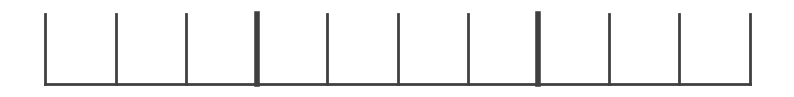

In [262]:
fig, ax = g.draw()

Let's create data on the grid (including the ghost cells) and visualize the PPM reconstruction.

In [263]:
a = g.scratch_array()
a[:] = [0.3, 1.0, 0.9, 0.8, 0.25, 0.1, 0.5, 0.55, 0.25, 0.1]
#g.fill_BCs(a)
a

array([0.3 , 1.  , 0.9 , 0.8 , 0.25, 0.1 , 0.5 , 0.55, 0.25, 0.1 ])

In [264]:
ppm = PPMInterpolant(g, a)

In [265]:
ppm.construct_parabola()

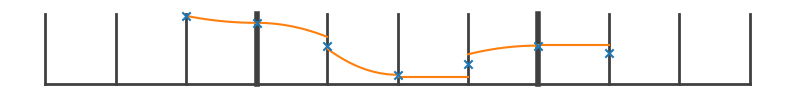

In [266]:
ppm.draw_parabola(ax)
ppm.mark_cubic(ax)
fig